# [1주차] 심화과제 - MNIST 예측 모델에 deep learning techniques 적용하기

구현 목표 : MNIST 데이터로 손글씨 이미지가 어떤 숫자를 의미하는지 분류하는 모델을 구현한다.

필요한 라이브러리를 import 한다.
GPU를 사용하기 위한 설정을 한다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# mac에 GPU를 사용하기 위한 설정
device = torch.device("mps")

trainset과 testset 준비한다.
PyTorch를 사용하기 위해 다차원 배열인 Tensor 형태로 변환한다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


trainset이 잘 만들어졌는지 확인하기 위해 전체 transet data의 개수와 첫 번째 data를 출력한다.

50000
torch.Size([3, 32, 32]) 6


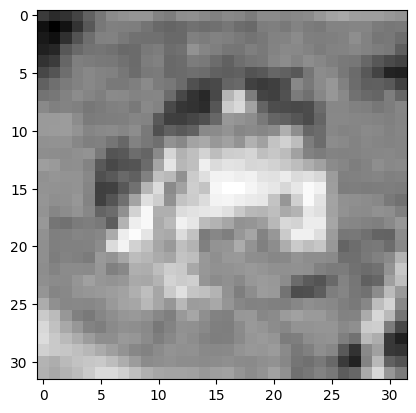

In [3]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

SGD를 위해 dataset을 여러 개의 batch로 나눈다.
여러 개의 batch로 나누면 데이터가 많아도 메모리가 부족하지 않게 gradient descent를 수행할 수 있다.
SGD는 랜덤으로 batch를 구성해야 잘 동작하기 때문에 trainloader에 shuffle=True로 설정한다.

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


첫 번째 batch를 출력하면 다음과 같다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


dataloader에 대한 model의 정확도를 측정하는 코드를 추가한다.

In [6]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

모델을 학습하면서 저장한 정확도를 plot으로 출력하는 함수를 선언한다.

In [7]:
def plot_acc(train_accs, test_accs, label1, label2):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

### SGD vs Adam

LeakyReLU을 사용하는 3-layer MLP 모델을 구현한다. 

In [8]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model = Model(32 * 32 * 3, 1024)

gradient descent를 수행해줄 optimizer를 구현한다. SGD와 Adam을 사용한다.

In [9]:
from torch.optim import SGD, Adam

lr = 0.001
model = model.to('mps')

sgd_optimizer = SGD(model.parameters(), lr=lr)
adam_optimizer = Adam(model.parameters(), lr=lr)

model을 학습한다.
SGD의 성능을 측정하기 위해 배열에 정확도를 계산하여 저장한다.

In [10]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

sgd_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    sgd_optimizer.step()

    total_loss += loss.item()
  sgd_train_acc_list.append(accuracy(model, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 450.2898955345154
Epoch   1 | Loss: 448.2156720161438
Epoch   2 | Loss: 446.4143657684326
Epoch   3 | Loss: 444.6605279445648
Epoch   4 | Loss: 442.82019305229187
Epoch   5 | Loss: 440.80369424819946
Epoch   6 | Loss: 438.61826181411743
Epoch   7 | Loss: 436.2262034416199
Epoch   8 | Loss: 433.66328024864197
Epoch   9 | Loss: 430.9483451843262
Epoch  10 | Loss: 428.03337717056274
Epoch  11 | Loss: 425.02383518218994
Epoch  12 | Loss: 422.0090298652649
Epoch  13 | Loss: 418.96238827705383
Epoch  14 | Loss: 416.14988017082214
Epoch  15 | Loss: 413.4155464172363
Epoch  16 | Loss: 410.87359714508057
Epoch  17 | Loss: 408.44449830055237
Epoch  18 | Loss: 406.23766922950745
Epoch  19 | Loss: 404.1861823797226
Epoch  20 | Loss: 402.1143682003021
Epoch  21 | Loss: 400.2425916194916
Epoch  22 | Loss: 398.4380189180374
Epoch  23 | Loss: 396.70708787441254
Epoch  24 | Loss: 395.0333775281906
Epoch  25 | Loss: 393.52414560317993
Epoch  26 | Loss: 392.010151386261
Epoch  27 | Loss

Adam의 성능을 측정하기 위해 배열에 정확도를 계산하여 저장한다.

In [11]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

adam_train_acc_list = []
adam_test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    adam_optimizer.step()

    total_loss += loss.item()
  adam_train_acc_list.append(accuracy(model, trainloader))
  adam_test_acc_list.append(accuracy(model, testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 375.59930872917175
Epoch   1 | Loss: 328.1931993961334
Epoch   2 | Loss: 311.5235651731491
Epoch   3 | Loss: 300.24834644794464
Epoch   4 | Loss: 289.6552879810333
Epoch   5 | Loss: 284.3459335565567
Epoch   6 | Loss: 275.8207520246506
Epoch   7 | Loss: 268.579909324646
Epoch   8 | Loss: 264.1532646417618
Epoch   9 | Loss: 256.9805306196213
Epoch  10 | Loss: 253.2964287996292
Epoch  11 | Loss: 244.6334846019745
Epoch  12 | Loss: 240.54299747943878
Epoch  13 | Loss: 235.8479495048523
Epoch  14 | Loss: 231.49070888757706
Epoch  15 | Loss: 226.51317048072815
Epoch  16 | Loss: 221.60944360494614
Epoch  17 | Loss: 217.3695189356804
Epoch  18 | Loss: 212.66790974140167
Epoch  19 | Loss: 208.49204736948013
Epoch  20 | Loss: 203.80094194412231
Epoch  21 | Loss: 197.64608144760132
Epoch  22 | Loss: 195.15967321395874
Epoch  23 | Loss: 187.4658601284027
Epoch  24 | Loss: 184.30605572462082
Epoch  25 | Loss: 179.63212287425995
Epoch  26 | Loss: 174.77636522054672
Epoch  27 | Los

SGD와 Adam의 성능을 비교한다.

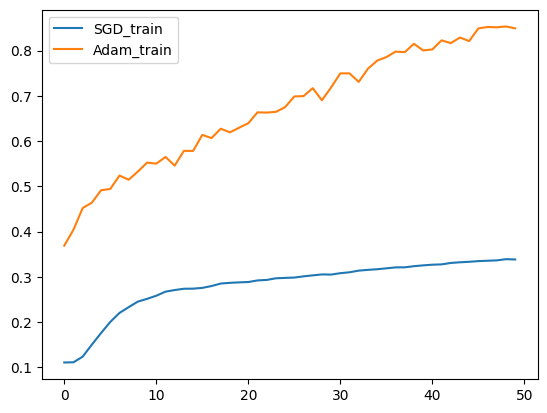

In [12]:
plot_acc(sgd_train_acc_list, adam_train_acc_list, 'SGD_train', 'Adam_train')

### LeakyReLU vs Sigmoid

LeakyReLU 모델을 구현한다.

In [13]:
from torch import nn


class ModelWithLeakyReLU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model_with_leaky_relu = ModelWithLeakyReLU(32 * 32 * 3, 1024)

Sigmoid 모델을 구현한다.

In [14]:
from torch import nn

class ModelWithSigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    # 0~9까지 각 클래스에 대한 확률을 출력하기 위해 dimension을 10으로 설정
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model_with_sigmoid = ModelWithSigmoid(32 * 32 * 3, 1024)

gradient descent를 수행해줄 optimizer를 구현한다. Adam을 사용한다.

In [15]:
from torch.optim import SGD, Adam

lr = 0.001
model_with_leaky_relu = model_with_leaky_relu.to('mps')
model_with_sigmoid = model_with_sigmoid.to('mps')

leaky_relu_optimizer = Adam(model_with_leaky_relu.parameters(), lr=lr)
sigmoid_optimizer = Adam(model_with_sigmoid.parameters(), lr=lr)

LeakyReLU 모델을 학습한다.

In [16]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

leaky_relu_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_with_leaky_relu.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model_with_leaky_relu(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    leaky_relu_optimizer.step()

    total_loss += loss.item()
  leaky_relu_train_acc_list.append(accuracy(model_with_leaky_relu, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 366.5918719768524
Epoch   1 | Loss: 324.9435832500458
Epoch   2 | Loss: 308.04026985168457
Epoch   3 | Loss: 294.34598910808563
Epoch   4 | Loss: 286.08939003944397
Epoch   5 | Loss: 279.07122457027435
Epoch   6 | Loss: 271.78538608551025
Epoch   7 | Loss: 264.5837889909744
Epoch   8 | Loss: 258.61038041114807
Epoch   9 | Loss: 252.97483897209167
Epoch  10 | Loss: 247.17654359340668
Epoch  11 | Loss: 241.95385938882828
Epoch  12 | Loss: 237.59200966358185
Epoch  13 | Loss: 230.62823128700256
Epoch  14 | Loss: 224.6441993713379
Epoch  15 | Loss: 221.06314808130264
Epoch  16 | Loss: 216.51463478803635
Epoch  17 | Loss: 209.17531949281693
Epoch  18 | Loss: 204.59889596700668
Epoch  19 | Loss: 197.99319887161255
Epoch  20 | Loss: 193.27585822343826
Epoch  21 | Loss: 188.05669432878494
Epoch  22 | Loss: 184.7066587805748
Epoch  23 | Loss: 178.74841213226318
Epoch  24 | Loss: 173.30557656288147
Epoch  25 | Loss: 166.23808974027634
Epoch  26 | Loss: 161.4167799949646
Epoch  

Sigmoid 모델을 학습한다.
Sigmoid는 모든 입력값을 0과 1 사이로 압축한다.

In [17]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

sigmoid_train_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model_with_sigmoid.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model_with_sigmoid(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    sigmoid_optimizer.step()

    total_loss += loss.item()
  sigmoid_train_acc_list.append(accuracy(model_with_sigmoid, trainloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 387.1187787055969
Epoch   1 | Loss: 338.52922105789185
Epoch   2 | Loss: 320.46667313575745
Epoch   3 | Loss: 308.71701288223267
Epoch   4 | Loss: 299.10929012298584
Epoch   5 | Loss: 292.0453370809555
Epoch   6 | Loss: 284.855175614357
Epoch   7 | Loss: 278.4482568502426
Epoch   8 | Loss: 273.6160749197006
Epoch   9 | Loss: 269.22095143795013
Epoch  10 | Loss: 266.00673472881317
Epoch  11 | Loss: 261.3293846845627
Epoch  12 | Loss: 257.19293320178986
Epoch  13 | Loss: 252.4950169324875
Epoch  14 | Loss: 249.70545995235443
Epoch  15 | Loss: 245.09141218662262
Epoch  16 | Loss: 241.30354952812195
Epoch  17 | Loss: 239.3215502500534
Epoch  18 | Loss: 235.28938853740692
Epoch  19 | Loss: 230.48440670967102
Epoch  20 | Loss: 227.92923206090927
Epoch  21 | Loss: 224.30266666412354
Epoch  22 | Loss: 221.37051379680634
Epoch  23 | Loss: 219.73735505342484
Epoch  24 | Loss: 215.20648658275604
Epoch  25 | Loss: 212.01117795705795
Epoch  26 | Loss: 209.94980013370514
Epoch  27 

LeakyReLU와 Sigmoid의 성능을 비교한다.

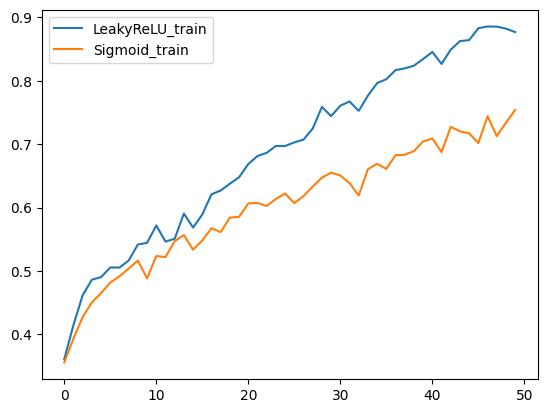

In [18]:
plot_acc(leaky_relu_train_acc_list, sigmoid_train_acc_list, 'LeakyReLU_train', 'Sigmoid_train')

Sigmoid는 조금 더 완만하게 변화하고, LeakyReLU는 조금 더 급격하게 변화한다.

### Dropout
Dropout 모델을 구현한다.

In [19]:
from torch import nn

class ModelWithDropout(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.layer3(x)

    return x


model_with_dropout = ModelWithDropout(32 * 32 * 3, 1024)

In [20]:
from torch.optim import Adam

lr = 0.001
model_with_dropout = model_with_dropout.to('mps')

optimizer = Adam(model_with_dropout.parameters(), lr=lr)

In [21]:
criterion = nn.CrossEntropyLoss()
n_epochs = 50

dropout_train_acc_list = []
dropout_test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    model_with_dropout.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('mps'), labels.to('mps')

    preds = model_with_dropout(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    dropout_train_acc_list.append(accuracy(model, trainloader))
    dropout_test_acc_list.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 369.78960847854614
Epoch   1 | Loss: 331.577011346817
Epoch   2 | Loss: 315.49702048301697
Epoch   3 | Loss: 304.41384720802307
Epoch   4 | Loss: 297.7803919315338
Epoch   5 | Loss: 291.1958314180374
Epoch   6 | Loss: 285.02668964862823
Epoch   7 | Loss: 280.2770208120346
Epoch   8 | Loss: 274.36386585235596
Epoch   9 | Loss: 271.12227642536163
Epoch  10 | Loss: 266.834166765213
Epoch  11 | Loss: 263.086571931839
Epoch  12 | Loss: 258.0477646589279
Epoch  13 | Loss: 254.30087411403656
Epoch  14 | Loss: 252.32765364646912
Epoch  15 | Loss: 245.87661921977997
Epoch  16 | Loss: 244.36605441570282
Epoch  17 | Loss: 240.5954874753952
Epoch  18 | Loss: 237.30045008659363
Epoch  19 | Loss: 236.26080667972565
Epoch  20 | Loss: 231.506478369236
Epoch  21 | Loss: 228.46710485219955
Epoch  22 | Loss: 226.0004540681839
Epoch  23 | Loss: 222.8453950881958
Epoch  24 | Loss: 221.16080504655838
Epoch  25 | Loss: 218.47845941781998
Epoch  26 | Loss: 215.26164323091507
Epoch  27 | Loss

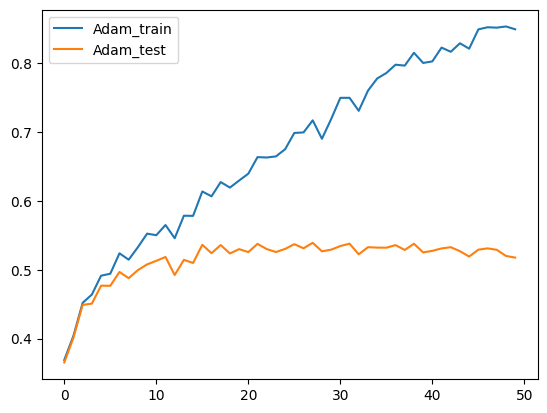

In [22]:
plot_acc(adam_train_acc_list, adam_test_acc_list, 'Adam_train', 'Adam_test')

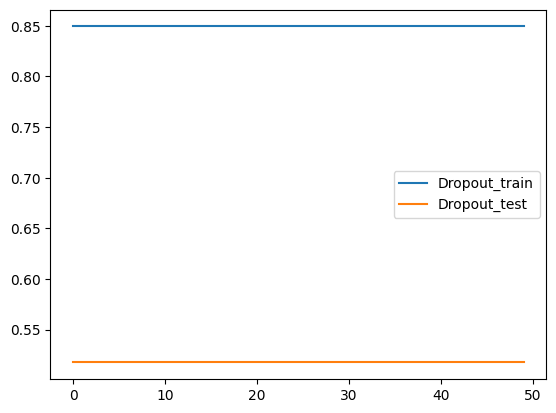

In [23]:
plot_acc(dropout_train_acc_list, dropout_test_acc_list, 'Dropout_train', 'Dropout_test')